# Approach 3: Multi-Armed Bandits

Curse: IS4242, Semster 1, 2024

Team: LLP


# 3.0 Setup

In [1]:
""" Import the necessary modules """

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
""" paths """

U_DATA = 'data/u.data'
U_GENRE = 'data/u.genre'
U_ITEM = 'data/u.item'
U_OCCUPATION = 'data/u.occupation'
U_USER = 'data/u.user'
UA_TEST = 'data/ua.test'
UA_TRAIN = 'data/ua.train'


## 3.1 Data Preprocessing & Exploration

### 3.1.1 Load the Data

#### 3.1.1.1 u.data

In [3]:
# Load the 'u.data' file.
df_all_data = pd.read_csv(
    filepath_or_buffer=U_DATA,
    sep='\t',
    names=[
        "user_id",
        "item_id",
        "rating",
        "timestamp"
    ]
)

print(df_all_data.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [4]:
df_all_data.describe().round(1)

,user_id,item_id,rating,timestamp
count,100000.0,100000.0,100000.0,100000.0
mean,462.5,425.5,3.5,883528851.5
std,266.6,330.8,1.1,5343856.2
min,1.0,1.0,1.0,874724710.0
25%,254.0,175.0,3.0,879448709.5
50%,447.0,322.0,4.0,882826944.0
75%,682.0,631.0,4.0,888259984.0
max,943.0,1682.0,5.0,893286638.0


#### 3.1.1.2 u.genre

In [5]:
df_genre = pd.read_csv(
    filepath_or_buffer=U_GENRE,
    sep='|',
    names=[
        "genre_name",
        "genre_id"
    ]
)
print(df_genre.head())

   genre_name  genre_id
0     unknown         0
1      Action         1
2   Adventure         2
3   Animation         3
4  Children's         4


In [6]:
print(f"\nNumber of genres is %d." % (df_genre.shape[0]))


Number of genres is 19.


#### 3.1.1.3 u.item

In [7]:
df_item = pd.read_csv(
    filepath_or_buffer=U_ITEM,
    sep='|',
    names=[
        "movie-id", 
        "movie-title", 
        "release-date", 
        "video-release-date",
        "IMDb-URL"
        ] + df_genre["genre_name"].tolist(),
    encoding='ISO-8859-1'
)

df_item.head()

,movie-id,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### 3.1.1.4 u.user

In [8]:
df_user = pd.read_csv(
    filepath_or_buffer=U_USER,
    sep='|',
    names=[
        "user_id",
        "user_age", 
        "user_gender", 
        "user_occupation", 
        "user_zip"
    ]
)
df_user.head()

,user_id,user_age,user_gender,user_occupation,user_zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


#### 3.1.1.5 ua.test

In [9]:
df_test = pd.read_csv(
    filepath_or_buffer=UA_TEST,
    sep='\t',
    names=[
      "user_id",
      "movie_id",
      "rating",
      "timestamp"  
    ]
)

df_test.head()
df_test.describe()

,user_id,movie_id,rating,timestamp
count,9430.000000,9430.000000,9430.000000,9.430000e+03
mean,472.000000,400.800954,3.587805,8.837354e+08
std,272.234934,306.859789,1.120240,5.360562e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,236.000000,182.000000,3.000000,8.794515e+08
50%,472.000000,303.000000,4.000000,8.833904e+08
75%,708.000000,566.000000,4.000000,8.886378e+08
max,943.000000,1664.000000,5.000000,8.932866e+08


In [10]:
df_train = pd.read_csv("data/ua.train", sep='\t', names=["user_id","rating","movie_id"])

df_train.head()
df_train.describe()

,user_id,rating,movie_id
count,90570.000000,90570.000000,9.057000e+04
mean,428.104891,3.523827,8.835073e+08
std,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,8.747247e+08
25%,174.000000,3.000000,8.794484e+08
50%,324.000000,4.000000,8.828143e+08
75%,636.000000,4.000000,8.882049e+08
max,1682.000000,5.000000,8.932866e+08


In [11]:
# maintain a map of dataframes to print their names too
# handy for dataframe iterations

df_map = {
    'df_all_data' : df_all_data,
    'df_genre': df_genre,
    'df_item': df_item,
    'df_user': df_user,
    'df_test': df_test,
    'df_train': df_train
}

### 3.1.2 Cleaning of data
Removing unwanted attributes from the dataframes.

#### 3.1.2.1 temporal data

In [12]:
""" Drop timestamp columns """


for _df_str in ['df_all_data', 'df_test', 'df_train']:
    _df = df_map[_df_str]
    if "timestamp" in _df.columns:
        _df.drop(
            columns=["timestamp"], 
            inplace=True
        )

    print('\n',_df_str,'\n', df_all_data.head())



 df_all_data 
    user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1

 df_test 
    user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1

 df_train 
    user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1


#### 3.1.2.2 movies with too few ratings (MAB specific)

In [13]:
""" find all the movies with >= ratings"""

item_id_counts = df_all_data['item_id'].value_counts()
print(item_id_counts.head())

print(f"\nThere are %d movies in total." % len(item_id_counts))

item_id_sup200 = item_id_counts[item_id_counts >= 200]
print(f"\nONLY %d of them have >= 200 ratings." % len(item_id_sup200))

item_id
50     583
258    509
100    508
181    507
294    485
Name: count, dtype: int64

There are 1682 movies in total.

ONLY 118 of them have >= 200 ratings.


### 3.1.3 Separate users into four groups (MAB specific) 
1. Male and <30 (young) :   'df_user_my'
1. Male and >=30 (old) :    'df_user_mo'
1. Female and <30 (young) : 'df_user_fy'
1. Female and >=30 (old) :  'df_user_fo'

In [14]:
user_mask_young = df_user['user_age'] < 30
user_mask_male = df_user['user_gender'] == "M"

In [15]:
df_user_my = df_user[user_mask_male & user_mask_young]
df_user_mo = df_user[user_mask_male & ~user_mask_young]
df_user_fy = df_user[~user_mask_male & user_mask_young]
df_user_fo = df_user[~user_mask_male & ~user_mask_young]

df_user_groups = {
    'my' : df_user_my,
    'mo' : df_user_mo,
    'fy' : df_user_fy,
    'fo' : df_user_fo
}

### 3.1.4 Visual Exploration

df

<Axes: xlabel='rating', ylabel='Count'>

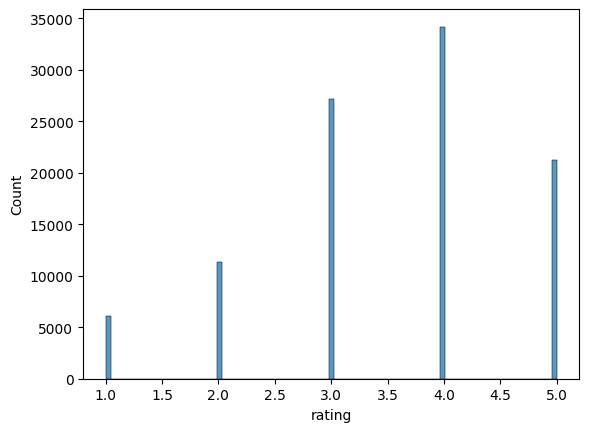

In [16]:
sns.histplot(df_all_data['rating'])

array([[<Axes: title={'center': 'user_id'}>]], dtype=object)

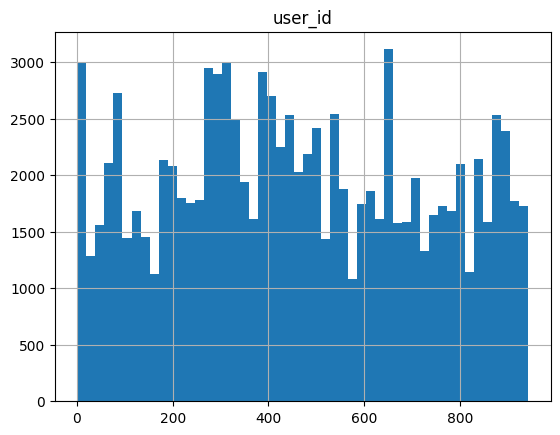

In [17]:
df_all_data.hist(bins=50, column='user_id')

In [18]:
for g_lbl, g_df in df_user_groups.items():
    print(f"%s has %d users." % (g_lbl, len(g_df)))

my has 292 users.
mo has 378 users.
fy has 117 users.
fo has 156 users.


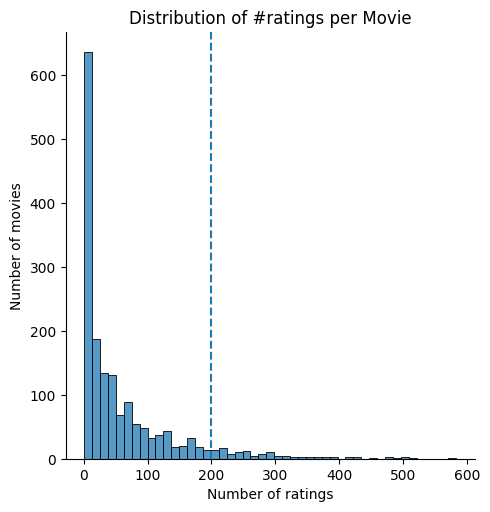

In [19]:
sns.displot(item_id_counts)
plt.axvline(x=200, linestyle='--')
plt.xlabel("Number of ratings")
plt.ylabel("Number of movies")
plt.title("Distribution of #ratings per Movie")
plt.show()

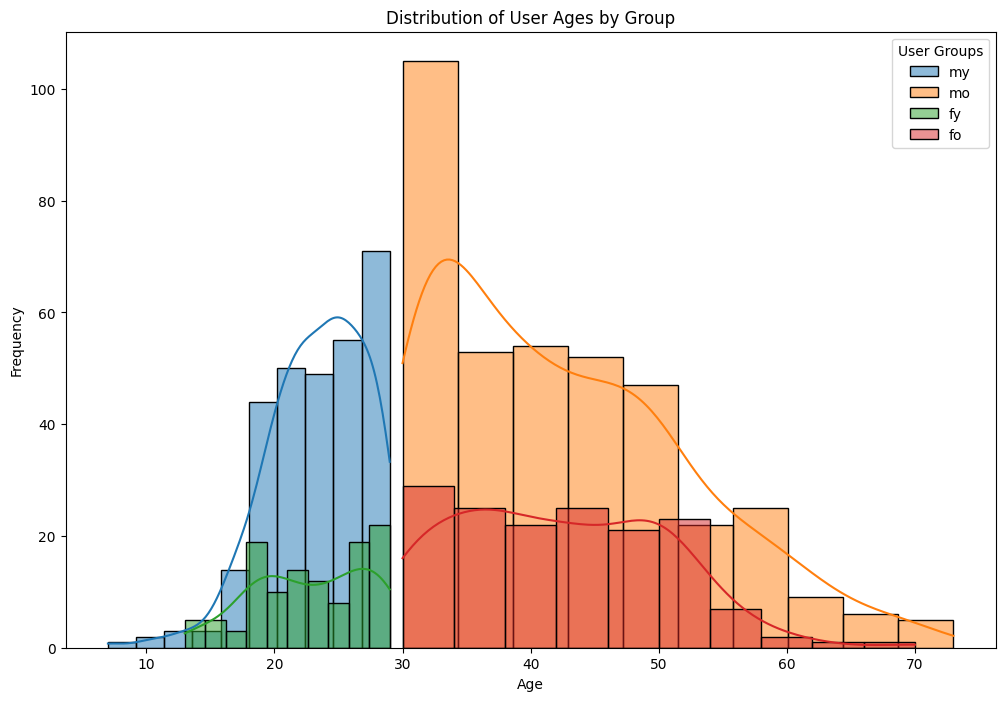

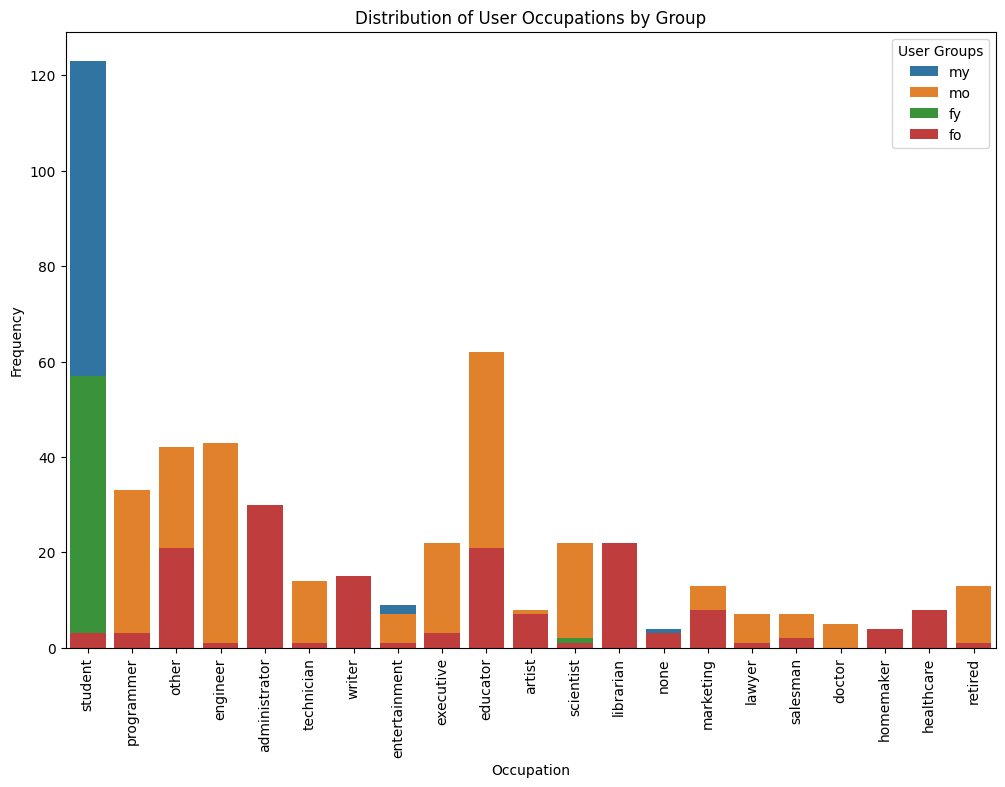

In [20]:
# TODO G verify
# Plotting the distribution of user ages for each group
plt.figure(figsize=(12, 8))
for g_lbl, g_df in df_user_groups.items():
    sns.histplot(g_df['user_age'], kde=True, label=g_lbl, bins=10)

plt.title('Distribution of User Ages by Group')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title='User Groups')
plt.show()

# TODO G verify
# Plotting the distribution of user occupations for each group
plt.figure(figsize=(12, 8))
for g_lbl, g_df in df_user_groups.items():
    occupation_counts = g_df['user_occupation'].value_counts()
    sns.barplot(x=occupation_counts.index, y=occupation_counts.values, label=g_lbl)

plt.title('Distribution of User Occupations by Group')
plt.xlabel('Occupation')
plt.ylabel('Frequency')
plt.legend(title='User Groups')
plt.xticks(rotation=90)
plt.show()

In [21]:
nan_count = df_item['release-date'].isna().sum()
non_nan_count = df_item['release-date'].notna().sum()

print(f"Number of NaN values: {nan_count}")
print(f"Number of non-NaN values: {non_nan_count}")

df_item.dropna(subset=['release-date'], inplace=True)
print(f"Number of NaN values: {nan_count}")
print(f"Number of rows after dropping NaN values: {len(df_item)}")



Number of NaN values: 1
Number of non-NaN values: 1681
Number of NaN values: 1
Number of rows after dropping NaN values: 1681


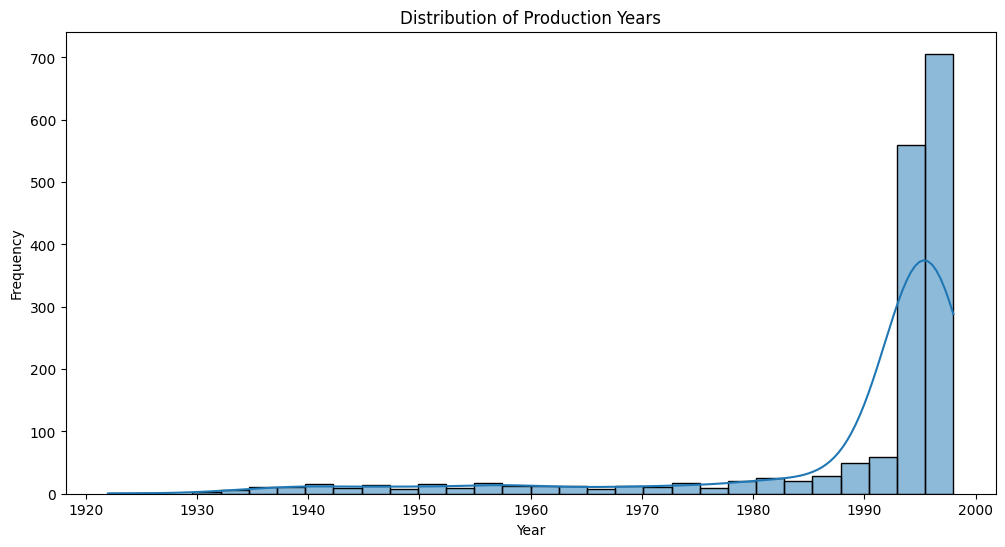

In [22]:
# Extract the production year from the 'release-date' column
df_item['production_year'] = df_item['release-date'].str.split('-').str[-1].astype(int)


# Plot the distribution of production years
plt.figure(figsize=(12, 6))
sns.histplot(df_item['production_year'], bins=30, kde=True)
plt.title('Distribution of Production Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Filter df_item to include only movies with item_id in item_id_sup200
df_item_filtered = df_item[df_item['movie-id'].isin(item_id_sup200.index)]

print(df_item_filtered.head())
print(f"\nNumber of movies after filtering: {len(df_item_filtered)}")

   movie-id              movie-title release-date  video-release-date  \
0         1         Toy Story (1995)  01-Jan-1995                 NaN   
3         4        Get Shorty (1995)  01-Jan-1995                 NaN   
6         7    Twelve Monkeys (1995)  01-Jan-1995                 NaN   
7         8              Babe (1995)  01-Jan-1995                 NaN   
8         9  Dead Man Walking (1995)  01-Jan-1995                 NaN   

                                            IMDb-URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
6  http://us.imdb.com/M/title-exact?Twelve%20Monk...        0       0   
7     http://us.imdb.com/M/title-exact?Babe%20(1995)        0       0   
8  http://us.imdb.com/M/title-exact?Dead%20Man%20...        0       0   

   Adventure  Animation  Children's  ...  Film-Noir  Horror  Musical  Mystery  \
0          0          1           1  ... 

In [24]:
df_item_filtered.describe()

,movie-id,video-release-date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,production_year
count,118.000000,0.0,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.0,...,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,237.813559,NaN,0.0,0.381356,0.169492,0.033898,0.067797,0.245763,0.093220,0.0,...,0.016949,0.050847,0.059322,0.067797,0.211864,0.186441,0.271186,0.144068,0.016949,1987.703390
std,167.405284,NaN,0.0,0.487791,0.376785,0.181739,0.252469,0.432374,0.291981,0.0,...,0.129631,0.220623,0.237234,0.252469,0.410372,0.391123,0.446468,0.352656,0.129631,12.274154
min,1.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1939.000000
25%,122.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1982.500000
50%,201.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1994.000000
75%,300.750000,NaN,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1996.000000
max,748.000000,NaN,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1997.000000


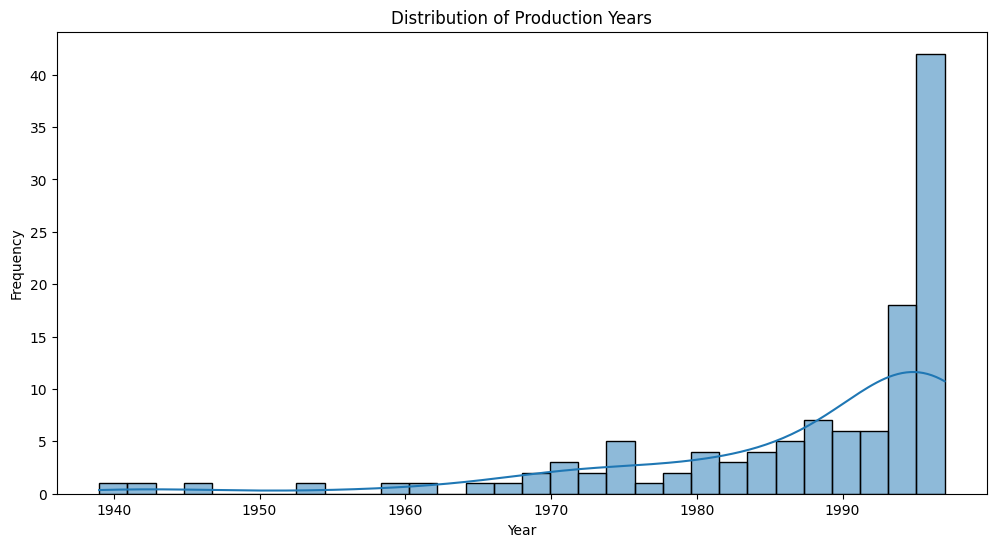

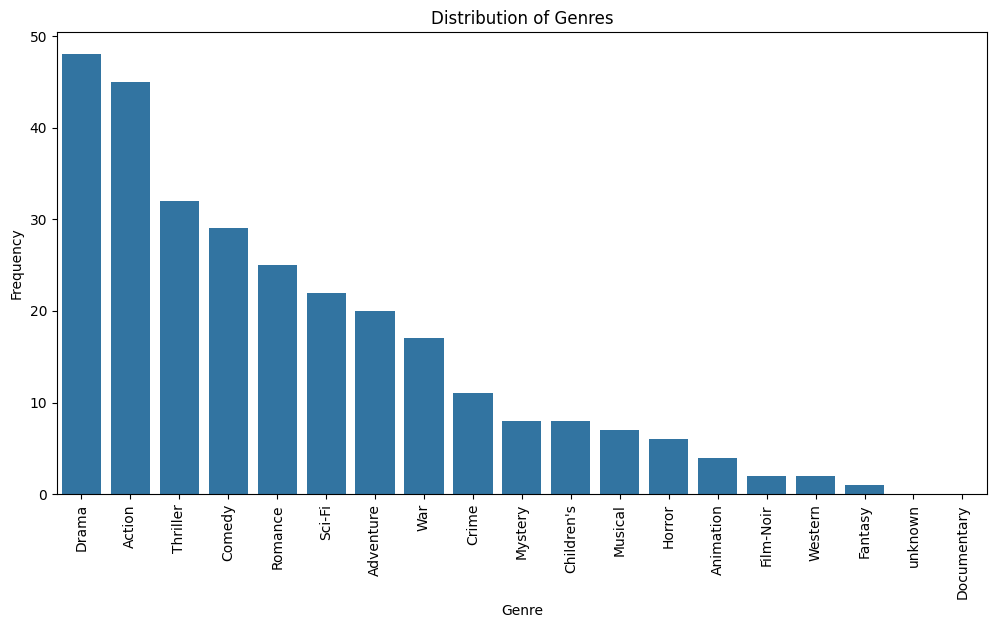

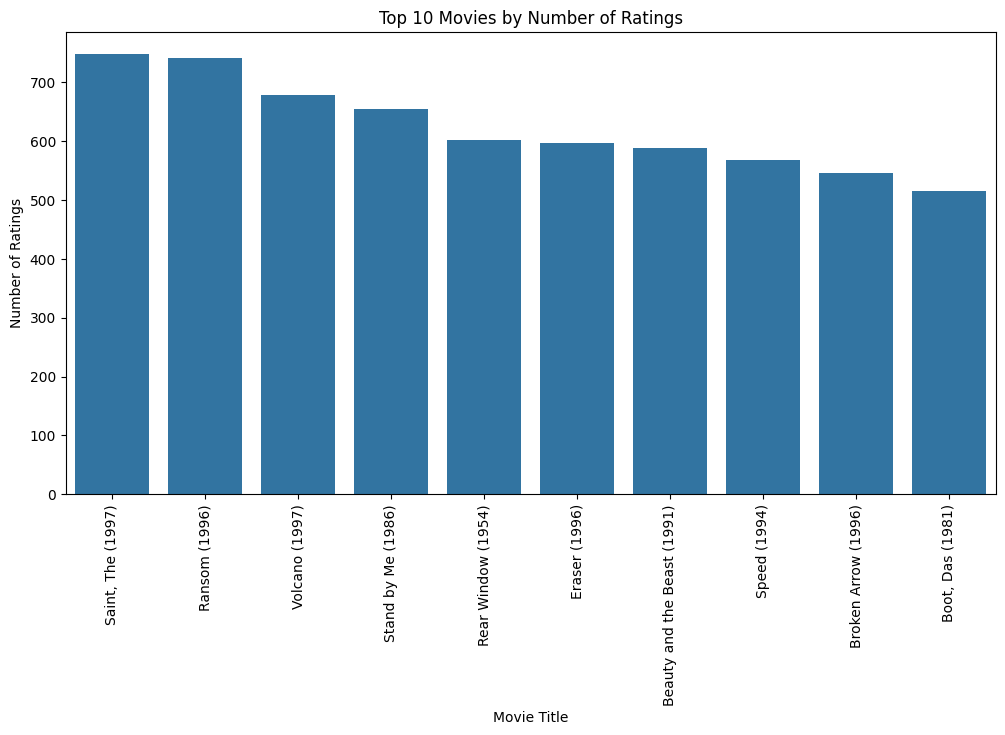

In [25]:
# Distribution of Production Years
plt.figure(figsize=(12, 6))
sns.histplot(df_item_filtered['production_year'], bins=30, kde=True)
plt.title('Distribution of Production Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Distribution of Genres
genre_columns = df_item_filtered.columns[5:-1]  # Exclude non-genre columns
genre_counts = df_item_filtered[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Top 10 Movies by Number of Ratings
top_10_movies = df_item_filtered.nlargest(10, 'movie-id')[['movie-title', 'movie-id']]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_movies['movie-title'], y=top_10_movies['movie-id'])
plt.title('Top 10 Movies by Number of Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()